In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
TRAIN_TEST_SPLIT = 3000
SHUFFER_BUFFER_SIZE = 1000

In [3]:
WINDOW_SIZE = 60
BATCH_SIZE = 100

In [4]:
data_path = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir=''
)

In [5]:
df_data = pd.read_csv(data_path, index_col=0)
df_data.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [6]:
time = df_data.index.to_numpy()
series = df_data['Monthly Mean Total Sunspot Number'].to_numpy()

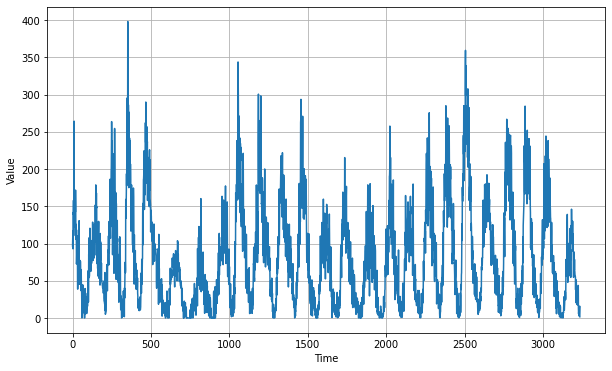

In [7]:
utils.plot_series(time, series)

In [8]:
time_train = time[:TRAIN_TEST_SPLIT]
x_train = series[:TRAIN_TEST_SPLIT]
time_val = time[TRAIN_TEST_SPLIT:]
x_val = series[TRAIN_TEST_SPLIT:]

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
def build_model(lr=1e-8):
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        keras.layers.LSTM(60, return_sequences=True), 
        keras.layers.LSTM(60), 
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 400.0)
    ])

    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss=keras.losses.Huber(), metrics=['mae'])
    return model

In [11]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [12]:
keras.backend.clear_session()

def lr_boost(epoch):
    return 1e-8 * 10**(epoch / 20)

lr_schedule = keras.callbacks.LearningRateScheduler(lr_boost)

model = build_model(1e-8)

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

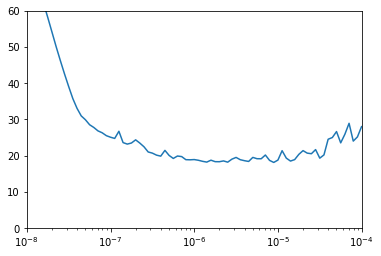

In [13]:
plt.figure()
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

In [14]:
keras.backend.clear_session()

model = build_model(1e-6)

history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
30/30 [==============================] - 0s 14ms/step - loss: 42.7682 - mae: 43.2655
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 28.7819 - mae: 29.2793
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 22.4928 - mae: 22.9876
Epoch 4/500
30/30 [==============================] - 0s 15ms/step - loss: 21.3681 - mae: 21.8615
Epoch 5/500
30/30 [==============================] - 0s 17ms/step - loss: 20.3529 - mae: 20.8458
Epoch 6/500
30/30 [==============================] - 0s 15ms/step - loss: 19.6989 - mae: 20.1905
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 19.5411 - mae: 20.0337
Epoch 8/500
30/30 [==============================] - 0s 15ms/step - loss: 18.8825 - mae: 19.3754
Epoch 9/500
30/30 [==============================] - 0s 15ms/step - loss: 19.0465 - mae: 19.5391
Epoch 10/500
30/30 [==============================] - 0s 15ms/step - loss: 18.7454 - mae: 19.2381
Epoch 11/500
30/30 [=========

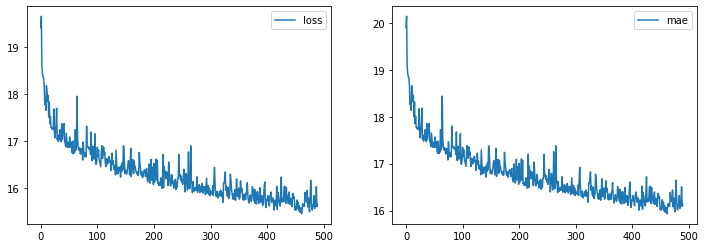

In [15]:
utils.plot_history(history, metrics=['loss', 'mae'], start=10)

mse = 411.7505, mae = 13.9356


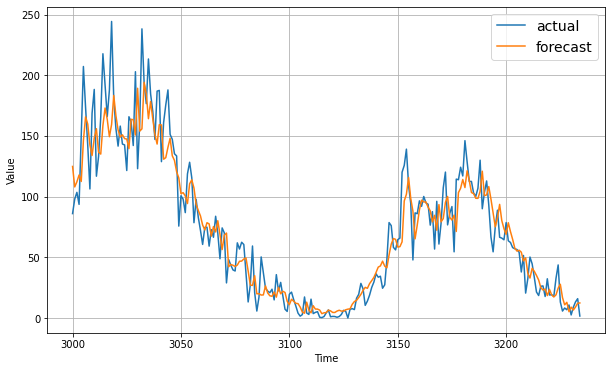

In [16]:
forecasts = []
for t in time_val:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, (0, -1)))[0][0]
    forecasts.append(forecast)

utils.evaluate(x_val, forecasts)

utils.plot_series(time_val, [x_val, forecasts], label=['actual', 'forecast'])